In [63]:
%matplotlib inline

import csv
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import os
import numpy as np

sns.set_style('whitegrid')
mpl.rc('text', usetex=True)
sns.set_context("notebook", font_scale=1.75)

# 1.  Generate results .tsv files

In [641]:
def parse_tarball(tarball, max_k, output_filename):
    with open(output_filename, "w") as out_f:
        labels = ['instance', 'timelimit', 'restartlimit', 'vertices', 
                  'method', 'time', 'k', 'cost'] + ['cost-' + str(s) for s in range(max_k)] + \
                 ['trees'] + ['trees-' + str(s) for s in range(max_k)] + \
                 ['LB', 'UB']
        with tarfile.open(tarball) as tar:
            out_f.write("\t".join(labels) + "\n")
            for tarinfo in tar:
                filename = tarinfo.name
                if str(filename).endswith("_summary.tsv"):
                    basename = os.path.basename(filename).rstrip("_summary.tsv")
                    s = basename.split("_")
                    method = s[0]
                    k = int(s[1])
                    timelimit = "nan"
                    restartlimit = "nan"
                    if (s[2][0] != "r"):
                        timelimit = int(s[2])
                    else:
                        restartlimit = int(s[2][1:])
                    m = int(s[3][1:])
                    instance = "_".join(s[3:6])
                    ff = tar.extractfile(filename)
                    ss = str(ff.readline()).lstrip("b'").rstrip("\n'").split("\t")
                    line2 = ff.readline()
                    ss2 = str(line2).lstrip("b'").rstrip("\n'").split("\t")
                    d = {}
                    d['instance'] = instance
                    d['timelimit'] = timelimit
                    d['restartlimit'] = restartlimit
                    d['vertices'] = m
                    for idx in range(len(ss)):
                        d[ss[idx]] = ss2[idx]
                        
                    # sort by number of trees
                    S = []
                    for s in range(k):
                        S.append((d['trees-%d' % s], d['cost-%d' % s]))
                    S=reversed(sorted(S))
                    for s, (trees, cost) in enumerate(S):
                        d['trees-%d' % s] = trees
                        d['cost-%d' % s] = cost
                    d['method'] = method

                    record = []
                    for label in labels:
                        if label in d:
                            record.append(d[label])
                        else:
                            record.append('nan')

                    out_f.write("\t".join(map(str, record)) + "\n")

In [642]:
parse_tarball("results/simulations.tar.gz", 5, "results.tsv")

In [643]:
parse_tarball("results/simulations_n9_S18_k10.tar.gz", 9, "results_n9_S18_k10.tsv")

# 2. Plot graphs

In [5]:
min_trees = 6
small = 10
big = 40

In [267]:
df = pd.read_table("results.tsv")
df = df[(df['trees'] >= min_trees)]
df['cat'] = df.apply(lambda row: "small" if row['trees'] <= small else "medium" if row['trees'] < big else "large", axis=1)
df['opt'] = df.apply(lambda row: float(row['time']) < float(row['timelimit']), axis=1)
df['norm_dist'] = df.apply(lambda row: float(row['cost']) / (float(row['trees']) * (float(row['vertices']) - 1)), axis=1)
df['method_timelimit'] = df.apply(lambda row : str(row['method']) + " [" \
                                  + (str(row['timelimit']) + " s]" if float(row['restartlimit']) != 100. else str(row['restartlimit']) + " restarts]"), axis=1)

for index, row in df.iterrows():
    if str(row['method']) == "CA":
#         print row["instance"],
#         print df[(df["instance"] == str(row["instance"])) 
#                & (df["method"] == "ILP") & (df["timelimit"] == 3600.0) & (df["k"]==2)]["opt"].iloc[0]
        if df[(df["instance"] == str(row["instance"])) & (df["cat"] == str(row["cat"]))
               & (df["method"] == "ILP") & (df["timelimit"] == 3600.0) & (df["k"]==float(row["k"]))]["opt"].iloc[0]:
            df.loc[index, "opt"] = True

nr_small = len(df[df['cat'] == "small"].instance.unique())
nr_medium = len(df[df['cat'] == "medium"].instance.unique())
nr_large = len(df[df['cat'] == "large"].instance.unique())

print("#Small instances:", nr_small)
print("#Medium instances:", nr_medium)
print("#Large instances:", nr_large)

('#Small instances:', 16)
('#Medium instances:', 15)
('#Large instances:', 14)


In [273]:
methods = ["ILP [3600.0 s]", "BF [3600.0 s]", "CA [3600.0 s]", "CA [100.0 restarts]"]
df_count = df[df["opt"]].groupby(["method_timelimit", "k", "cat"]).count()["instance"].unstack(["cat"]).fillna(0).reset_index()
for cat in ["small", "medium", "large"]:
    print "\multirow{4}{*}{%s (%d total)} " % (cat, len(df[df['cat'] == cat].instance.unique())),
    for k in range(2,6):
        print "& %d &" % k,
#         for method in methods:
#             print df_count[(df_count["method_timelimit"] == method) & (df_count["k"] == k)][cat].iloc[0]
        print " & ".join([str(int(df_count[(df_count["method_timelimit"] == method) & (df_count["k"] == k)][cat].iloc[0])) for method in methods]),
        print "\\\\"

\multirow{4}{*}{small (16 total)}  & 2 & 16 & 16 & 16 & 16 \\
& 3 & 16 & 16 & 16 & 16 \\
& 4 & 16 & 16 & 16 & 16 \\
& 5 & 16 & 14 & 16 & 16 \\
\multirow{4}{*}{medium (15 total)}  & 2 & 15 & 13 & 15 & 15 \\
& 3 & 13 & 7 & 13 & 13 \\
& 4 & 12 & 0 & 12 & 12 \\
& 5 & 10 & 0 & 10 & 10 \\
\multirow{4}{*}{large (14 total)}  & 2 & 3 & 0 & 3 & 3 \\
& 3 & 0 & 0 & 0 & 0 \\
& 4 & 0 & 0 & 0 & 0 \\
& 5 & 0 & 0 & 0 & 0 \\


In [549]:
df[df['opt'] & (df['method_timelimit'] == "ILP [3600.0 s]") & (df['cat'] == "small") & (df['k'] == 2)][["instance", "trees"]]

,instance,trees
171,n9_S0_k5,7
194,n11_S139_k10,8
848,n9_S27_k10,6
871,n11_S35_k5,10
1414,n11_S139_k5,10
1530,n11_S115_k5,6
1714,n9_S18_k10,9
1788,n11_S115_k10,6
1876,n9_S56_k10,6
2361,n9_S31_k10,6


In [ ]:
df.cost

In [490]:
def plot_norm_dist_single(df, ax, method, instance):
    labels = list(sorted(df[(df['method_timelimit'] == method) & (df['instance'] == instance)]['k'].unique()))
    r = range(len(labels))


    df2 = df[(df['method_timelimit'] == method) & (df['instance'] == instance)]
    df2.fillna(0, inplace=True)
    
    n = df2[df2['k'] == 2]["trees"].iloc[0]
    m = df2[df2['k'] == 2]["vertices"].iloc[0]

    dist = [df2[df2['k'] == s]["norm_dist"].iloc[0] for s in labels]

    # plot
    barWidth = 0.55
    bottoms = [ 0 for i in r ]
    b = []
    b.append(plt.bar(r, dist, color=sns.color_palette()[0], width=barWidth, axes=ax))
    
#     ax.legend(b, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
#     ax.set_xticks(r, [1,3,5])
    ax.set_ylabel("normalized distance")
#     ax.set_ylim((0,50))
#     ax.set_yticks(np.arange(0, 50, 10))
    ax.grid(axis="x", b=False)
#     ax.set_xticklabels(labels)
    ax.set_xlabel("\#clusters $k$")
    
    dist2 = [float(s) / n - 2 * np.log(1- df2[df2['k'] == s]["norm_dist"].iloc[0]) for s in labels]
    dist3 = [np.log(n) * s - 2 * np.log(1- df2[df2['k'] == s]["norm_dist"].iloc[0]) for s in labels]
    dist3 = [float(s) / n for s in labels]
    dist4 = [np.log(n) * s - 2 * np.log(n*(1- df2[df2['k'] == s]["norm_dist"].iloc[0])) for s in labels]
    ax2 = ax.twinx()
    ax2.set_ylim((0,1))
    plt.plot(r, dist4, color=sns.color_palette("Set2", 50)[1], axes=ax2)
#     plt.plot(r, dist3, color=sns.color_palette("Set2", 50)[1], axes=ax2)
#     plt.plot(r, dist4, color=sns.color_palette("Set2", 50)[2], axes=ax2)
#     print(dist4)

In [665]:
def plot_cost(df, ax, method, instance):
    labels = list(sorted(df[(df['method_timelimit'] == method) & (df['instance'] == instance)]['k'].unique()))
    r = range(len(labels))
#     print(labels)

    df2 = df[(df['method_timelimit'] == method) & (df['instance'] == instance)]
    df2.fillna(0, inplace=True)
    
    n = df2[df2['k'] == 2]["trees"].iloc[0]
    m = df2[df2['k'] == 2]["vertices"].iloc[0]

    totals = [df2[df2['k'] == s]["cost"].iloc[0] for s in labels]
    bars = [[float(df2[df2['k'] == s]["cost-%d" % (ss - 1)].iloc[0]) / (n*(m-1)) for s in labels] for ss in labels]
    
    cols = sns.color_palette("Set2", 8)
    if len(labels) > 8:
        cols = cols + [cols[-1]] * (len(labels) - 8)

    # plot
    barWidth = 0.55
    bottoms = [ 0 for i in r ]
    b = []
    for i in r:
        b.append(plt.bar(labels, bars[i], bottom=bottoms, color=sns.color_palette("Paired", len(labels))[i], width=barWidth, axes=ax))
        bottoms = [i+j for i,j in zip(bottoms, bars[i])]

    ax.legend(b, labels, loc="upper left", ncol=3, bbox_to_anchor=(0.05, 1.02), title="cluster")
#     print r
#     print labels
#     print ax.get_xticks()
    ax.set_xticks(r, labels)
    ax.set_ylabel("norm.~distance $\overline{d}(\mathcal{T},\mathcal{R},\sigma)$")
    ax.set_ylim((0,1))
#     ax.set_yticks(np.arange(0, 50, 10))
    ax.grid(axis="x", b=False)
#     ax.set_xticklabels(['0'] + labels)
#     ax.set_xlabel("\#clusters $k$")
    ax.set_xlim((0.5,labels[-1] + 0.5))
    
    dist2 = [float(s) / n - 2 * np.log(1- df2[df2['k'] == s]["norm_dist"].iloc[0]) for s in labels]
#     dist3 = [np.log(n) * s - 2 * np.log(1- df2[df2['k'] == s]["norm_dist"].iloc[0]) for s in labels]
#     dist3 = [float(s) / n for s in labels]
    dist4 = [np.log(n) * s - 2 * n * np.log((1- df2[df2['k'] == s]["norm_dist"].iloc[0])) for s in labels]
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.set_ylabel("BIC value")
#     ax2.set_ylim((0,1))

    tmp = plt.plot(labels, dist4, color="black", axes=ax2)
    ax2.legend(tmp, ["BIC"], loc="center right")

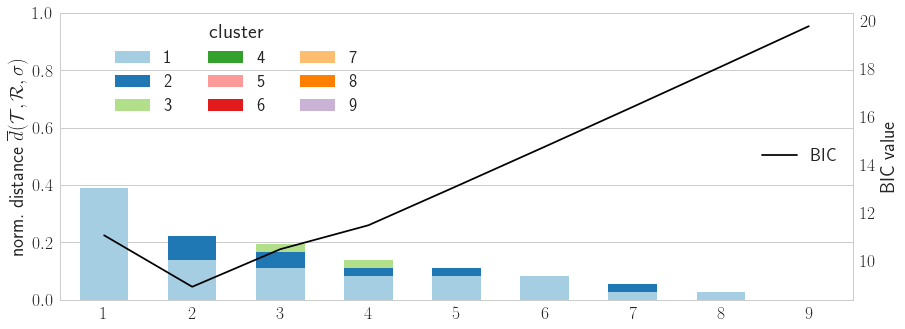

In [666]:
df_long = pd.read_table("results_n9_S18_k10.tsv")
# df_long = df_long[(df_long['trees'] >= min_trees)]
# df_long['cat'] = df_long.apply(lambda row: "small" if row['trees'] <= small else "medium" if row['trees'] < big else "large", axis=1)
# df_long['opt'] = df_long.apply(lambda row: float(row['time']) < float(row['timelimit']), axis=1)
df_long['norm_dist'] = df_long.apply(lambda row: float(row['cost']) / (float(row['trees']) * (float(row['vertices']) - 1)), axis=1)
df_long['method_timelimit'] = df_long.apply(lambda row : str(row['method']) + " [" \
                                  + (str(row['timelimit']) + " s]" if float(row['restartlimit']) != 100. else str(row['restartlimit']) + " restarts]"), axis=1)


plot_cost(df_long, plt.gca(), "CA [100 restarts]", "n9_S18_k10")
plt.gcf().set_size_inches(13, 5) 
plt.tight_layout()

In [645]:
def plot_nr_trees(df, ax, method, instance):
    labels = list(sorted(df[(df['method_timelimit'] == method) & (df['instance'] == instance)]['k'].unique()))
    r = range(len(labels))

    df2 = df[(df['method_timelimit'] == method) & (df['instance'] == instance)]
    df2.fillna(0, inplace=True)
    
    n = df2[df2['k'] == 2]["trees"].iloc[0]

    totals = [df2[df2['k'] == s]["trees"].iloc[0] for s in labels]
    bars = [[df2[df2['k'] == s]["trees-%d" % (ss - 1)].iloc[0] for s in labels] for ss in labels]
    
    cols = sns.color_palette("Set2", 8)
    if len(labels) > 8:
        cols = cols + [cols[-1]] * (len(labels) - 8)

    # plot
    barWidth = 0.55
    bottoms = [ 0 for i in r ]
    b = []
    for i in r:
        b.append(plt.bar(labels, bars[i], bottom=bottoms, color=sns.color_palette("Paired", len(labels))[i], width=barWidth, axes=ax))
        bottoms = [i+j for i,j in zip(bottoms, bars[i])]

#     ax.legend(b, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
    ax.set_xticks(r, labels)
    ax.set_ylabel("\#trees $n_s$ per cluster $s$")
#     ax.set_ylim((0,50))
#     ax.set_yticks(np.arange(0, 50, 10))
    ax.grid(axis="x", b=False)
#     ax.set_xticklabels(['0'] + labels)
    ax.set_xlabel("\#clusters $k$")
    ax.set_xlim((0.5,labels[-1] + 0.5))

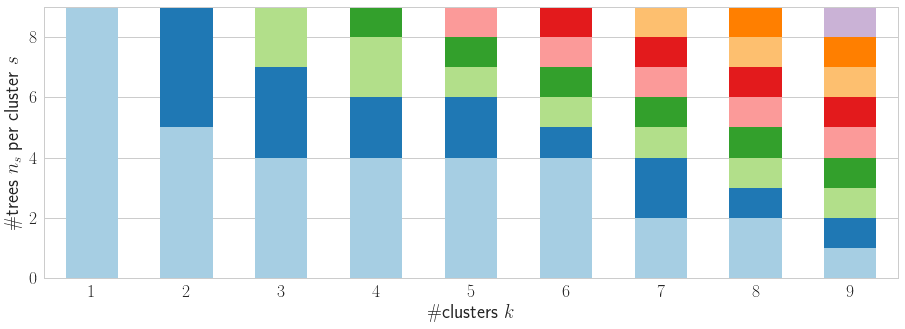

In [646]:
plot_nr_trees(df_long, plt.gca(), "CA [100 restarts]", "n9_S18_k10")
plt.gcf().set_size_inches(13, 5) 
plt.tight_layout()

KeyError: 'cat'

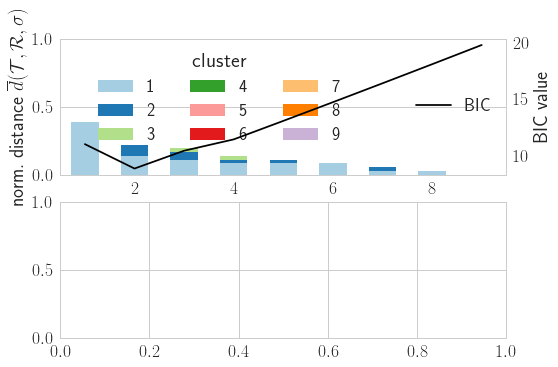

In [667]:
nrRows = 2
nrCols = 1
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_cost(df_long, plt.gca(), "CA [100 restarts]", "n9_S18_k10")
idx += 1
ax = plt.subplot(nrRows, nrCols, idx)
plot_nr_trees(df_long, plt.gca(), "CA [100 restarts]", "n9_S18_k10")
idx += 1

plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("BIC.pdf")

In [359]:
def plot_opt(df, ax, method):
#     d = { 'small'  : len(df[df['cat'] == "small"].instance.unique()), 
#           'medium' : len(df[df['cat'] == "medium"].instance.unique()),
#           'large'  : len(df[df['cat'] == "large"].instance.unique())
#         }
    r = range(5)
    labels = ["1", "2", "3", "4", "5"]
    df2 = df[df['opt'] & (df['timelimit'] == 3600) & (df['method'] == method)]
    df2 = df2.groupby(["method", "timelimit", "k", "cat"]).count()['instance'].unstack(["cat"])
    df2 = df2.reset_index()
    df2.fillna(0, inplace=True)
#     df2['method-cat'] = df2.apply(lambda row : str(row['method']) + str(row['cat']), axis=1)
#     df2['instance'] = df2.apply(lambda row : row['instance'] / d[row['cat']], axis=1)
    
    totals = [i+j+k for i,j,k in zip(df2["small"], df2["medium"], df2["large"])]
    greenBars = [i for i,j in zip(df2["small"], totals)]
    orangeBars = [i for i,j in zip(df2["medium"], totals)]
    blueBars = [i for i,j in zip(df2["large"], totals)]
    
    # plot
    barWidth = 0.55
    # Create green Bars
    k1 = plt.bar(r, greenBars, color=sns.color_palette()[0], width=barWidth, axes=ax)
    # Create orange Bars
    k2 = plt.bar(r, orangeBars, bottom=greenBars, color=sns.color_palette()[1], 
                 width=barWidth, axes=ax)
    # Create blue Bars
    k3 = plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], 
                 color=sns.color_palette()[2], width=barWidth, axes=ax)
    ax.legend([k1,k2,k3], ["small", "medium", "large"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
    ax.set_xticks(r, [1,3,5])
    ax.set_ylabel("\#instances solved by %s" % method)
    ax.set_ylim((0,50))
#     ax.set_yticks(np.arange(0, 50, 10))
    ax.grid(axis="x", b=False)
    ax.set_xticklabels(['0'] + labels)
    ax.set_xlabel("\#clusters $k$")

[16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 14.0]


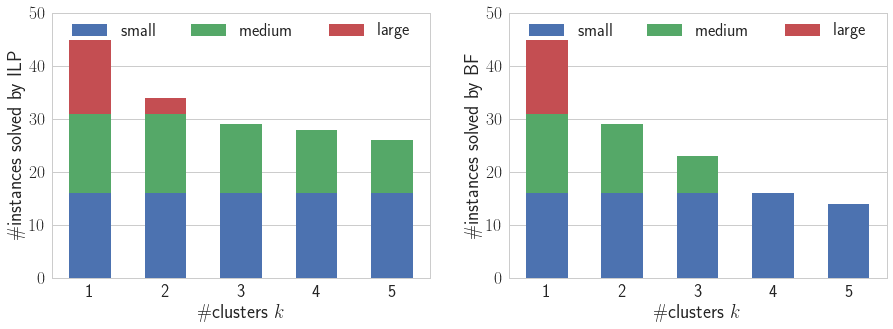

In [310]:
nrRows = 1
nrCols = 2
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_opt(df, ax, "ILP")
idx += 1
ax = plt.subplot(nrRows, nrCols, idx)
plot_opt(df, ax, "BF")

plt.gcf().set_size_inches(13, 5) 
plt.tight_layout()
plt.savefig("opt.pdf")

In [648]:
def plot_nr_trees(df, ax, cat, color_offset):
    df2 = df[(df['method'] == "CA") & (df['timelimit'] == 60.) & (df['k'] == 2) & (df['cat'] == cat)]
    sns.stripplot(data=df2, x="cat", y="trees", alpha=.4, split=True, linewidth=1, jitter=.1, 
                  palette=sns.color_palette()[color_offset:], ax=ax)
    sns.boxplot(data=df2, x="cat", y="trees", showfliers=False,
                     palette=sns.color_palette()[color_offset:], ax=ax)
#     ax.set(yscale="log")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:3], labels[0:3], title="", loc="upper left")
    ax.set_ylim((0, None))
    ax.set_xlabel("")
    ax.set_ylabel("\#trees $n$")

In [663]:
def plot_norm_dist(df, ax, cat=None):
    if cat:
        df2 = df[(df['k'] > 1) & (df['cat'] == cat)]
    else:
        df2 = df[(df['k'] > 1)]
    sns.stripplot(data=df2, x="k", y="norm_dist", hue="method_timelimit",
                  alpha=.4, split=True, linewidth=1, jitter=.1,
                  hue_order=["CA [100.0 restarts]", "CA [3600.0 s]", "ILP [3600.0 s]"],
                 palette=sns.color_palette("Set2", 10), ax=ax)
    sns.boxplot(data=df2, x="k", y="norm_dist", hue="method_timelimit",
                     showfliers=False, 
                     hue_order=["CA [100.0 restarts]", "CA [3600.0 s]", "ILP [3600.0 s]"],
                     palette=sns.color_palette("Set2", 10), ax=ax)
#     ax.set(yscale="log")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:3], labels[0:3], title="")
    ax.set_ylim((0, 1))
    ax.set_xlabel("\#clusters $k$ (%s)" % cat)
    ax.set_ylabel("norm.~distance $\overline{d}(\mathcal{T},\mathcal{R},\sigma)$")

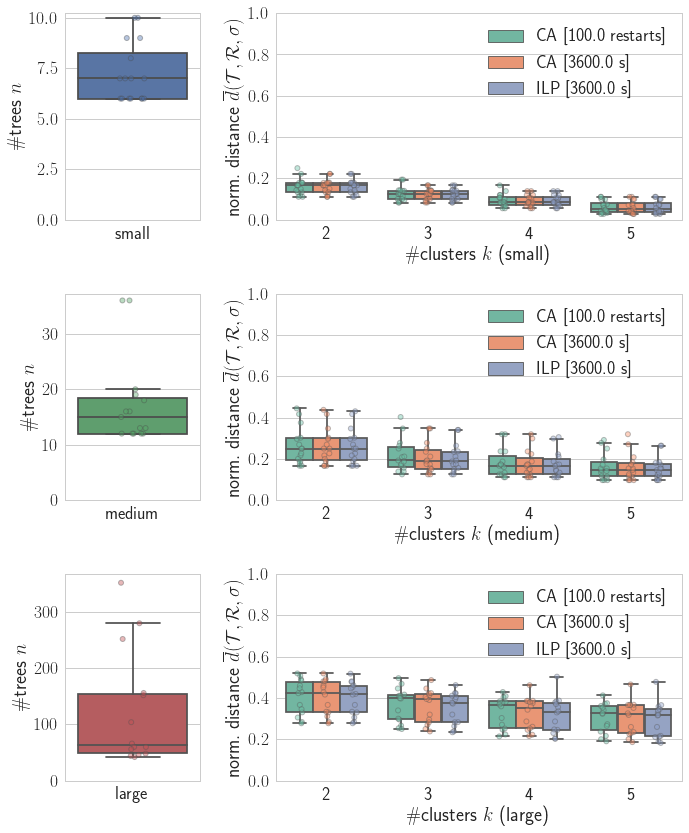

In [664]:
nrRows = 3
nrCols = 2
idx = 1

gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1, 3]) 
for offset, cat in enumerate(["small", "medium", "large"]):
    ax = plt.subplot(gs[idx-1])
    plot_nr_trees(df, ax, cat, offset)
    idx += 1
    ax = plt.subplot(gs[idx-1])
    plot_norm_dist(df, ax, cat)
    idx += 1

plt.gcf().set_size_inches(10, 12)
plt.tight_layout()
plt.savefig("all.pdf")

In [219]:
def plot_ilp_gap(df, ax, timelimit, cat=None):
    df2 = df[(df['method'] == 'ILP') & (df['timelimit'] == timelimit)]
    df2['gap'] = (df2['UB'] - df2['LB']) / df2['UB']
    if cat:
        df2 = df2[(df2['k'] > 1) & (df2['cat'] == cat)]
    else:
        df2 = df2[(df2['k'] > 1)]
        
    sns.stripplot(data=df2, x="k", y="gap",
                  alpha=.4, split=True, linewidth=1, jitter=.1,
                  palette=sns.color_palette("Set2", 10)[2:3], ax=ax)
    sns.boxplot(data=df2, x="k", y="gap",
                     showfliers=False,
                     palette=sns.color_palette("Set2", 10)[2:3], ax=ax)
#     ax.set(yscale="log")
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[0:3], labels[0:3], title="")
    ax.set_ylim((0, 1))
    ax.set_xlabel("\#clusters $k$ (%s)" % cat)
    ax.set_ylabel("optimality gap (UB - LB)/UB")

/Users/melkebir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


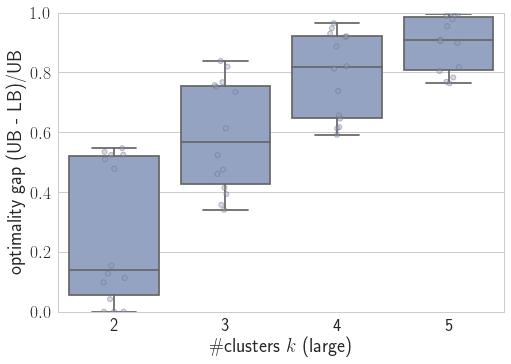

In [220]:
plot_ilp_gap(df, plt.gca(), 3600.0, "large")

In [221]:
df.head()

,instance,timelimit,restartlimit,vertices,method,time,k,cost,cost-0,cost-1,...,trees-1,trees-2,trees-3,trees-4,LB,UB,cat,opt,norm_dist,method_timelimit
1,n13_S43_k10,180.0,NaN,13,CA,180.0660,5,4,2,2.0,...,2.0,1.0,1.0,1.0,NaN,NaN,small,False,0.047619,CA [180.0 s]
2,n9_S48_k5,60.0,NaN,9,CA,60.0290,5,84,24,34.0,...,12.0,6.0,4.0,5.0,NaN,NaN,medium,False,0.291667,CA [60.0 s]
3,n9_S27_k10,60.0,NaN,9,CA,60.0088,5,2,2,0.0,...,1.0,1.0,1.0,1.0,NaN,NaN,small,False,0.041667,CA [60.0 s]
4,n13_S84_k5,3600.0,NaN,13,BF,3600.0500,4,988,976,4.0,...,3.0,4.0,2.0,NaN,NaN,NaN,large,False,0.527778,BF [3600.0 s]
5,n11_S27_k5,30.0,NaN,11,CA,30.0949,5,112,36,34.0,...,13.0,6.0,6.0,8.0,NaN,NaN,large,False,0.243478,CA [30.0 s]


## 2.1 Instances solved to optimality

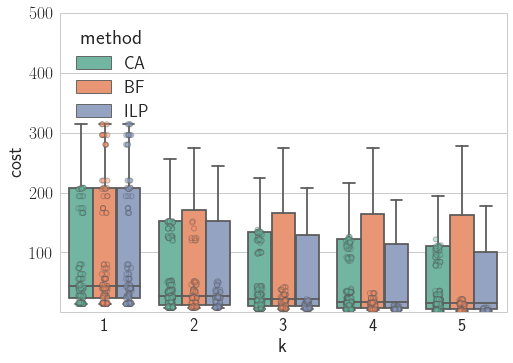

In [248]:
sns.stripplot(data=df[df['opt']], x="k", y="cost", hue="method", alpha=.4, split=True, linewidth=1, jitter=.1, 
              palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df, x="k", y="cost", hue="method", showfliers=False,
                palette=sns.color_palette("Set2", 10))
ax.set(yscale="linear")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3], title="method", loc="upper left")
ax.set_ylim((1, 500))
ax.set_xlabel("k")
ax.set_ylabel("cost")
plt.savefig("solutions.pdf")

In [255]:
# df_small[(df_small['k'] == 5) & (df_small['method'] == "ILP")].sort_values(['instance'])

In [256]:
# df_small[(df_small['k'] == 4) & (df_small['method'] == "ILP")].sort_values(['instance'])

In [257]:
# df_small[(df_small['k'] == 2) & (df_small['method'] == "ILP")]

In [266]:
df.groupby(['k', 'method']).count()

instance  time  cost  num_trees
k method                                 
1 BF            47    47    47         47
  CA            47    47    47         47
  ILP           47    47    47         47
2 BF            47    47    47         47
  CA            47    47    47         47
  ILP           47    47    47         47
3 BF            47    47    47         47
  CA            47    47    47         47
  ILP           47    47    47         47
4 BF            47    47    47         47
  CA            47    47    47         47
  ILP           47    47    47         47
5 BF            47    47    47         47
  ILP           47    47    47         47

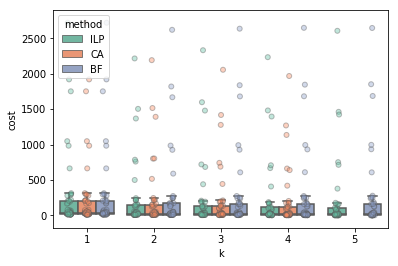

In [263]:
sns.stripplot(data=df, x="k", y="cost", hue="method", alpha=.4, split=True, linewidth=1, jitter=.1, 
              palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df, x="k", y="cost", hue="method", showfliers=False,
                palette=sns.color_palette("Set2", 10))
ax.set(yscale="linear")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3], title="method", loc="upper left")
# ax.set_ylim((1, 500))
ax.set_xlabel("k")
ax.set_ylabel("cost")
plt.savefig("solutions.pdf")

## 2.2 Optimal results

In [119]:
df = pd.read_table("results600optimal.tsv")
df_small = df[df['num_trees'] <= 20]
df_med = df[(df['num_trees'] > 20) & (df['num_trees'] <= 100)]
df_big = df[df['num_trees'] > 100]

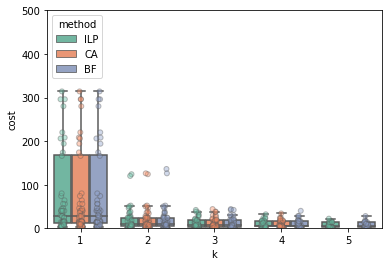

In [123]:
sns.stripplot(data=df, x="k", y="cost", hue="method", alpha=.4, split=True, linewidth=1, jitter=.1, 
              palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df, x="k", y="cost", hue="method", showfliers=False,
                palette=sns.color_palette("Set2", 10))
ax.set(yscale="linear")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3], title="method", loc="upper left")
ax.set_ylim((1, 500))
ax.set_xlabel("k")
ax.set_ylabel("cost")
plt.savefig("solutions.pdf")

## 2.3 Coordinate-Ascent only

In [135]:
df = pd.read_table("resultscaonly.tsv")
df_small = df[df['num_trees'] <= 20]
df_med = df[(df['num_trees'] > 20) & (df['num_trees'] <= 100)]
df_big = df[df['num_trees'] > 100]

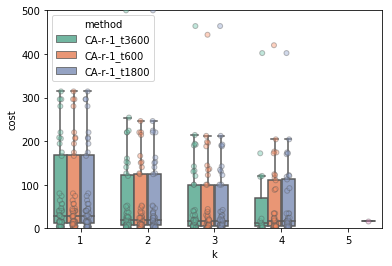

In [138]:
sns.stripplot(data=df, x="k", y="cost", hue="method", alpha=.4, split=True, linewidth=1, jitter=.1, 
              palette=sns.color_palette("Set2", 10))
ax = sns.boxplot(data=df, x="k", y="cost", hue="method", showfliers=False,
                palette=sns.color_palette("Set2", 10))
ax.set(yscale="linear")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3], title="method", loc="upper left")
ax.set_ylim((1, 500))
ax.set_xlabel("k")
ax.set_ylabel("cost")
plt.savefig("solutions.pdf")